In [360]:
import numpy as np
import pandas as pd
from pprint import pprint
import itertools
import operator
%matplotlib inline
import matplotlib.pyplot as plt

# input data

In [383]:
age_start  = 24
detection = 1     # Clinically detected = 0, screen detected = 1 (webのsymptoms -> 0) unknown = 9
size = 10    # Tumour size mm
grade= 3     # Tumour grade unknown = 9
nodes = 5     # Number positive nodes
er = 1     # ER+ = 1, ER- = 0
her2 = 0     # HER2+ = 1, HER2- = 0, missing = 9
ki67 = 1     # KI67+ = 1, KI67- = 0, missing = 9
chemo_gen = 3     # Chemo generation 0, 2 or 3 only
horm = 1     # Hormone therapy Yes = 1, no = 0
traz = 0     # Trastuzumab therapy Yes = 1, no = 0
bis = 1    # Bisphosphonate therapy Yes = 1, no = 0

In [384]:
#screen gradeの調整
#screen =  0.204 if screen == 2 else screen
#grade = 2.13 if grade == 9 else grade
max_time = 15
time = np.array(range(1,max_time+1))
grade_val = 2.13 if grade == 2 else grade


# 層別化

$$ 
\begin{align}
    ER+ : \ H_c(t)  &= exp\big(0.7424402 - \frac{7.527762}{\sqrt{t}} - 1.812513 \times \frac{log(t)}{\sqrt{t}}\big) \\
    ER- : \ H_c(t)  &= exp\big(-1.156036 + \frac{0.4707332}{t^2} - \frac{3.51355}{t}\big)
\end{align}
$$

In [385]:
if er == 1:
    # data_point
    age_mfp_1 = (age_start/10)**-2-0.0287449295 
    age_mfp_2 = (age_start/10)**-2*np.log(age_start/10)-0.0510121013 
    size_mfp = np.log(size/100)+1.545233938 
    nodes_mfp = np.log((nodes+1)/10)+1.387566896 
    grade_mfp =  grade
    detection_mfp = 0.204 if detection == 9 else detection
    her2_mfp = 1
    ki67_mfp = 1
    
    # weight
    age_beta_1 = 34.53642 
    age_beta_2 = -34.20342  
    size_beta = 0.7530729 
    nodes_beta = 0.7060723 
    grade_beta = 0.746655 
    detection_beta = -0.22763366
    her2_beta = 0.2413 if her2 == 1 else -0.0762 if her2 == 0 else 0
    ki67_beta = 0.14904 if ki67 == 1 else -0.11333 if ki67 == 0 else 0
    
    
else:
    # data_point
    age_mfp_1 = age_start-56.3254902 
    age_mfp_2 = 0  
    size_mfp = (size/100)**0.5-0.5090456276  
    nodes_mfp = np.log((nodes+1)/10)+1.086916249   
    grade_mfp = 1 if grade == 2 or grade == 3 else 0
    detection_mfp = 0
    her2_mfp = 1
    ki67_mfp = 1
    
    # weight
    age_beta_1 = 0.0089827
    age_beta_2 = 0
    size_beta = 2.093446
    nodes_beta = 0.6260541
    grade_beta = 1.129091 
    detection_beta = 0
    her2_beta = 0.2413 if her2 == 1 else -0.0762 if her2 == 0 else 0
    ki67_beta = 0
    
x_1 = np.array([age_mfp_1,age_mfp_2,detection_mfp,size_mfp,grade_mfp,nodes_mfp,her2_mfp,ki67_mfp])
w_1 = np.array([age_beta_1,age_beta_2,detection_beta,size_beta,grade_beta,nodes_beta,her2_beta,ki67_beta])
pi = np.dot(w_1,x_1)
pi

3.6832056161439497

In [386]:
c_mfp = 1 
h_mfp = 1 
# h10_mfp = 1
t_mfp = 1
b_mfp = 1

c_beta = 0 if chemo_gen == 0 else -0.248 if chemo_gen == 2 else -0.446
h_beta = -0.3857 if horm == 1 and er == 1 else 0
# h10_beta = [horm for i in range(10)] + [horm-0.26 for i in range(len(time)-10)]
t_beta = -0.3567 if her2 == 1 and traz == 1 else 0
b_beta = -0.198 if bis == 1 else 0

x_2 = np.array([c_mfp,h_mfp,t_mfp,b_mfp])
w_2 = np.array([c_beta,h_beta,t_beta,b_beta])
rx = np.dot(w_2,x_2)
print(rx)
print(f"c{chemo_gen}h{horm}t{traz}b{bis}")

-1.0297
c3h1t0b1


In [387]:
# Other mortality prognostic index (mi)
mi = 0.0698252*((age_start/10)**2-34.23391957)


In [388]:
input_data = pd.read_csv("./input_data.csv")
patient1 = input_data.query(" pID == 1")
event = 10

In [396]:
class Patient:
    """Patient class

    Patientごとの生存時間解析を行うクラス
    
    Attributes:
        # 患者の情報
        age (int): 患者の年齢
        detection (int): 発見契機 symptoms detected = 0, screen detected = 1, unknown = 2
        size (float): Tumour size (mm)
        grade (int) : Tumour grade 1, 2 or 3 only
        nodes (int) : がんが転移したリンパ節の数
        er (int) : ER+ = 1, ER- = 0
        her2 (int) : her2+ = 1, her2- = 0 missing = 2
        ki67 (int) : ki67+ = 1, ki67- = 0 missing = 2
        event (int) : event発生の有無 0, 1
        duration (int) : event発生時間
        
        # Tretment Options
        chemo_gen (int) : Chemo generation 0, 2 or 3 only 
        horm (int) :  Hormone therapy Yes = 1, no = 0
        traz (int) : Trastuzumab therapy Yes = 1, no = 0
        bis (int) : Bisphosphonate therapy Yes = 1, no = 0
        treatment_options (str) : 患者が行っている治療法の結合 -> "c0:h1:t0:b1"
        
        # other
        max_time (int) : 打ち切りまでの時間（年）
        time 
    
    TODO:
    - 分岐(modelの種類)が何個あるか
    - 
        
    """
    def __init__(self,patient_data):
        # 患者の情報
        self.patient_data = patient_data
        self.age =  patient_data["age"][0]
        
        self.detection = patient_data['detection'][0]
        self.detection =  0.204 if self.detection == 2 else self.detection
        
        self.size = patient_data['tumour_size'][0]
        
        self.grade = patient_data['tumour_grade'][0]
        self.grade = 2.13 if self.grade == 9 else self.grade
        
        self.nodes = patient_data['nodes'][0]
        self.er = patient_data['er'][0]
        self.her2 = patient_data['her2'][0]
        self.ki67 = patient_data['ki67'][0]
        
        # Tretment Options
        self.chemo_gen = patient_data['chemotherapy'][0]
        self.horm = patient_data['hormonetherapy'][0]
        self.traz = patient_data['trastuzumab'][0]
        self.bis = patient_data['bisphosphonates'][0]
        self.event = patient_data['event'][0]
        self.duration = patient_data['duration'][0]
        self.treatment_options = f"c{self.chemo_gen}:h{self.horm}:t{self.traz}:b{self.bis}"
        
        # other
        self.max_time = 15
        self.time = np.array(range(1,self.max_time+1))
        self._set_model()

        
    def get_patient_data(self):
        """患者の入力情報を辞書式で返すメソッド

        Returns:
            dict: 患者の情報
        """
        columns = list(self.patient_data.columns)
        data = self.patient_data.values[0]
        param_dict = {col:datum for col, datum in zip(columns, data)}
        self.params = param_dict
        return param_dict
    
    def print_patient_data(self):
        pprint(self.get_patient_data())
    
    def _set_model(self):
        """患者の情報からモデルの重みを決定するメソッド

        Returns:
            np.array:重みの情報
        """
        if self.er == 1:
            # data_point
            age_mfp_1 = (self.age/10)**-2-0.0287449295 
            age_mfp_2 = (self.age/10)**-2*np.log(self.age/10)-0.0510121013 
            size_mfp = np.log(self.size/100)+1.545233938 
            nodes_mfp = np.log((self.nodes+1)/10)+1.387566896 
            grade_mfp =  self.grade
            detection_mfp = 0.204 if self.detection == 9 else self.detection
            her2_mfp = 1
            ki67_mfp = 1
            
            # weight
            age_beta_1 = 34.53642 
            age_beta_2 = -34.20342  
            size_beta = 0.7530729 
            nodes_beta = 0.7060723 
            grade_beta = 0.746655 
            detection_beta = -0.22763366
            her2_beta = 0.2413 if self.her2 == 1 else -0.0762 if self.her2 == 0 else 0
            ki67_beta = 0.14904 if self.ki67 == 1 else -0.11333 if self.ki67 == 0 else 0
            
            
        else:
            # data_point
            age_mfp_1 = self.age-56.3254902 
            age_mfp_2 = 0  
            size_mfp = (self.size/100)**0.5-0.5090456276  
            nodes_mfp = np.log((self.nodes+1)/10)+1.086916249   
            grade_mfp = 1 if self.grade == 2 or self.grade == 3 else 0
            detection_mfp = 0
            her2_mfp = 1
            ki67_mfp = 1
            
            # weight
            age_beta_1 = 0.0089827
            age_beta_2 = 0
            size_beta = 2.093446
            nodes_beta = 0.6260541
            grade_beta = 1.129091 
            detection_beta = 0
            her2_beta = 0.2413 if self.her2 == 1 else -0.0762 if self.her2 == 0 else 0
            ki67_beta = 0
            
        x_1 = np.array([age_mfp_1,age_mfp_2,detection_mfp,size_mfp,grade_mfp,nodes_mfp,her2_mfp,ki67_mfp])
        w_1 = np.array([age_beta_1,age_beta_2,detection_beta,size_beta,grade_beta,nodes_beta,her2_beta,ki67_beta])
        pi = np.dot(w_1,x_1)
 
        c_mfp = 1 
        h_mfp = 1 
        # h10_mfp = 1
        t_mfp = 1
        b_mfp = 1

        c_beta = 0 if chemo_gen == 0 else -0.248 if chemo_gen == 2 else -0.446
        h_beta = -0.3857 if horm == 1 and er == 1 else 0
        # h10_beta = [horm for i in range(10)] + [horm-0.26 for i in range(len(time)-10)]
        t_beta = -0.3567 if her2 == 1 and traz == 1 else 0
        b_beta = -0.198 if bis == 1 else 0

        x_2 = np.array([c_mfp,h_mfp,t_mfp,b_mfp])
        w_2 = np.array([c_beta,h_beta,t_beta,b_beta])
        rx = np.dot(w_2,x_2)
        
        self.coef_ = {"w_1": w_1, "x_1": x_1, "w_2": w_2, "x_2": x_2}
        self.base = "ER+" if self.er == 1 else "ER-"
        self.pi = pi
        self.rx = rx
        self.polynomial = pi + rx
    
    def _other_causes_model(self):
        """癌が原因でない時のモデル
        
        """
        # Other mortality prognostic index (mi)
        mi = 0.0698252*((self.age/10)**2-34.23391957)
        
        # Generate cumulative baseline other mortality
        base_m_cum_oth = np.exp(-6.052919 + (1.079863*np.log(self.time)) + (0.3255321*self.time**0.5))
        
        # Generate cumulative survival non-breast mortality
        s_cum_oth = np.exp(-np.exp(mi)*base_m_cum_oth)
        
        # Convert cumulative mortality rate into cumulative risk
        m_cum_oth = 1- s_cum_oth
        
        # Annual other mortality rate
        m_oth = np.array([i for i in m_cum_oth])

        for i in range(1,15):
            m_oth[i] = m_cum_oth[i] - m_cum_oth[i-1]
          
    
    def _set_baseline_with_cancer(self):
        """癌が原因のモデルのベースラインをセットするメソッド
        
        """
        # Generate cumulative baseline breast mortality
        if self.base == "ER+":
            base_m_cum_br = np.exp(0.7424402 - 7.527762/self.time**0.5 - 1.812513*np.log(self.time)/self.time**0.5)
        else:
            base_m_cum_br = np.exp(-1.156036 + 0.4707332/self.time**2 - 3.51355/self.time)
            
        # Annual cancer mortality rate
        base_m_br = np.array([i for i in base_m_cum_br])

        for i in range(1,15):
            base_m_br[i] = base_m_cum_br[i] - base_m_cum_br[i-1]
        
        print("base",base_m_cum_br)
        # Generate the annual breast cancer specific mortality rate
        m_br = base_m_br * np.exp(self.polynomial)
        
        #累積和
        m_cum_br = np.array(list(itertools.accumulate(m_br)))
        
        return m_br

    def predict_cumulative_hazard_function(self):
        pass
    
    def predict_survival_function(self):
        
        
        pass
    
    def score(self):
        pass
    
    def get_params(self):
        pass

In [401]:
patient = Patient(patient1)
patient.rx

-1.0297

In [374]:
cum_arr = np.array(list(itertools.accumulate(arr)))

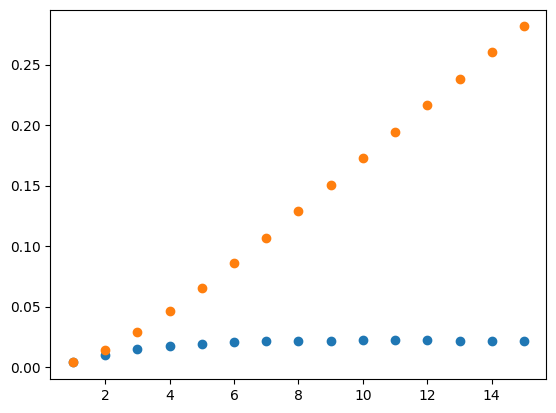

In [375]:
plt.scatter(x=list(range(1,16)), y=arr)
plt.scatter(x=list(range(1,16)), y=cum_arr)

In [372]:
arr

array([0.00375644, 0.01025587, 0.0146456 , 0.01745135, 0.01926552,
       0.02044204, 0.02119405, 0.02165504, 0.02191184, 0.02202279,
       0.02202818, 0.02195645, 0.02182811, 0.02165814, 0.02145767])

In [120]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines.datasets import load_rossi
rossi = load_rossi()

In [121]:
rossi

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...
427,52,0,1,31,0,1,0,1,3
428,52,0,0,20,1,0,0,1,1
429,52,0,1,20,1,1,1,1,1
430,52,0,0,29,1,1,0,1,3


In [129]:
estimator = CoxPHSurvivalAnalysis()
y = rossi[['arrest','week']] #目的変数 
X = rossi.drop(columns=['arrest','week']) #説明変数

#dtypeの指定 ?はbool型　i8はint64
tp = np.dtype([('arrest','?'), ('week', 'i8')])

structured_y = np.zeros(len(y), dtype=tp)
structured_y['arrest'] = y['arrest']
structured_y['week'] = y['week']
estimator.fit(X,structured_y)

CoxPHSurvivalAnalysis()

In [224]:
estimator.coef_

array([-0.37902189, -0.05724593,  0.31412977, -0.1511146 , -0.43278257,
       -0.08498284,  0.09111154])

In [200]:
out = estimator.predict_cumulative_hazard_function(X, return_array=True)

In [201]:
%matplotlib inline
import matplotlib.pyplot as plt 

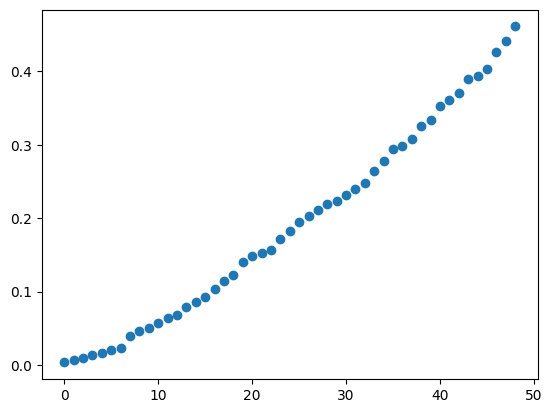

In [223]:
out = iter(out)
y = next(out)
x = np.array([i for i in range(len(y))])
plt.scatter(x=x,y=y)

In [203]:
y

array([0.00239112, 0.00478934, 0.00718926, 0.00959404, 0.01200639,
       0.01442881, 0.01686457, 0.02906362, 0.03401251, 0.03649398,
       0.04150468, 0.04661444, 0.04917529, 0.05689028, 0.0621005 ,
       0.06734078, 0.07522825, 0.08325478, 0.0886663 , 0.10229328,
       0.10780378, 0.11057082, 0.11335363, 0.12449961, 0.13292615,
       0.14153812, 0.14731504, 0.15312408, 0.15899112, 0.16194478,
       0.16788069, 0.17385925, 0.1799224 , 0.19215304, 0.20144154,
       0.21394773, 0.21711637, 0.2234796 , 0.23626624, 0.24277227,
       0.25582955, 0.26245396, 0.26912791, 0.28262391, 0.28603444,
       0.29288663, 0.31018726, 0.32071431, 0.33497937])

In [167]:
next(out)

array([0.99886293, 0.99772379, 0.99658514, 0.99544548, 0.99430354,
       0.99315816, 0.99200781, 0.98626646, 0.98394681, 0.98278574,
       0.98044544, 0.97806461, 0.97687359, 0.9732942 , 0.97088433,
       0.96846657, 0.9648388 , 0.96116102, 0.95868936, 0.95249349,
       0.94999938, 0.94874945, 0.94749406, 0.94248246, 0.93871122,
       0.93487258, 0.93230642, 0.9297331 , 0.92714128, 0.92583922,
       0.92322801, 0.92060548, 0.91795345, 0.91262699, 0.90860249,
       0.90321186, 0.90185114, 0.89912476, 0.8936711 , 0.89090891,
       0.88539106, 0.88260474, 0.87980646, 0.87417487, 0.87275745,
       0.8699166 , 0.86278503, 0.85847427, 0.85266716])